# Machine learning for Credit Card Transactions

In [2]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

## Load Dataset and build graph

In [5]:
import pandas as pd
df = pd.read_csv("data/fraudTrain.csv")

In [6]:
# 기본적인 정보 확인
df.info()
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [7]:
# 일반 거래와 사기 거래의 비율
df["is_fraud"].value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

우리가 다루는 IBM 합성데이터에서 LI-Small데이터와 비율이 비슷한 것으로 확인

In [10]:
# 샘플링

# 원래 코드 -> 에러: append가  Pandas 1.4.0에서 제거됨
# df = df[df["is_fraud"]==0].sample(frac=0.50, random_state=42).append(df[df["is_fraud"] == 1])

# 코드 수정
df = pd.concat([
    df[df["is_fraud"]==0].sample(frac=0.20, random_state=42),  # 20% 정상거래 샘플링
    df[df["is_fraud"]==1]  # 사기거래 전체 포함
])

In [11]:
df.shape

(265340, 23)

In [16]:
# 사용되는 데이터의 수
df["is_fraud"].value_counts()

is_fraud
0    257834
1      7506
Name: count, dtype: int64

In [18]:
# 사기거래 비율
df["is_fraud"].value_counts(normalize=True)

is_fraud
0    0.971712
1    0.028288
Name: proportion, dtype: float64

사기거래비율이 2.83%대가 됨.

## 데이터 정보
 - 2019년 1월 1일부터 2020년 12월 31일까지의 정상 거래와 사기 거래를 포함하는 가상의 신용카드 거래로 구성
 - 800명의 판매자 풀과 거래를 수행하는 1000명의 고객의 신용카드가 포함

### 사용할 컬럼
- 23개의 컬럼 중 사용할 컬럼만 기록
- `index`: 각 행의 식별자, 행 번호 / 정수
- `cc_num`: 고객의 신용카드 번호 / 문자열
- `merchant`: 판매자(상점) 이름
- `amt`: 트랜잭션 수(달러로 표기)
- `is_fraud`: 사기 여부 표시, 0인 경우 정상거래이고, 1인 경우 사기거래. / 이진수

In [22]:
# df["cc_num"].values.tolist()

In [24]:
# 이분(bipartite) 그래프 구축
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)   # 그래프 구축
    
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")

    # edge에 두 가지 속성 할당: label, weight
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

In [26]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

In [28]:
G = build_graph_bipartite(df, nx.Graph())

In [30]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G)

True

In [32]:
import networkx as nx
print(type(G))    # class 'networkx.classes.graph.Graph'

<class 'networkx.classes.graph.Graph'>


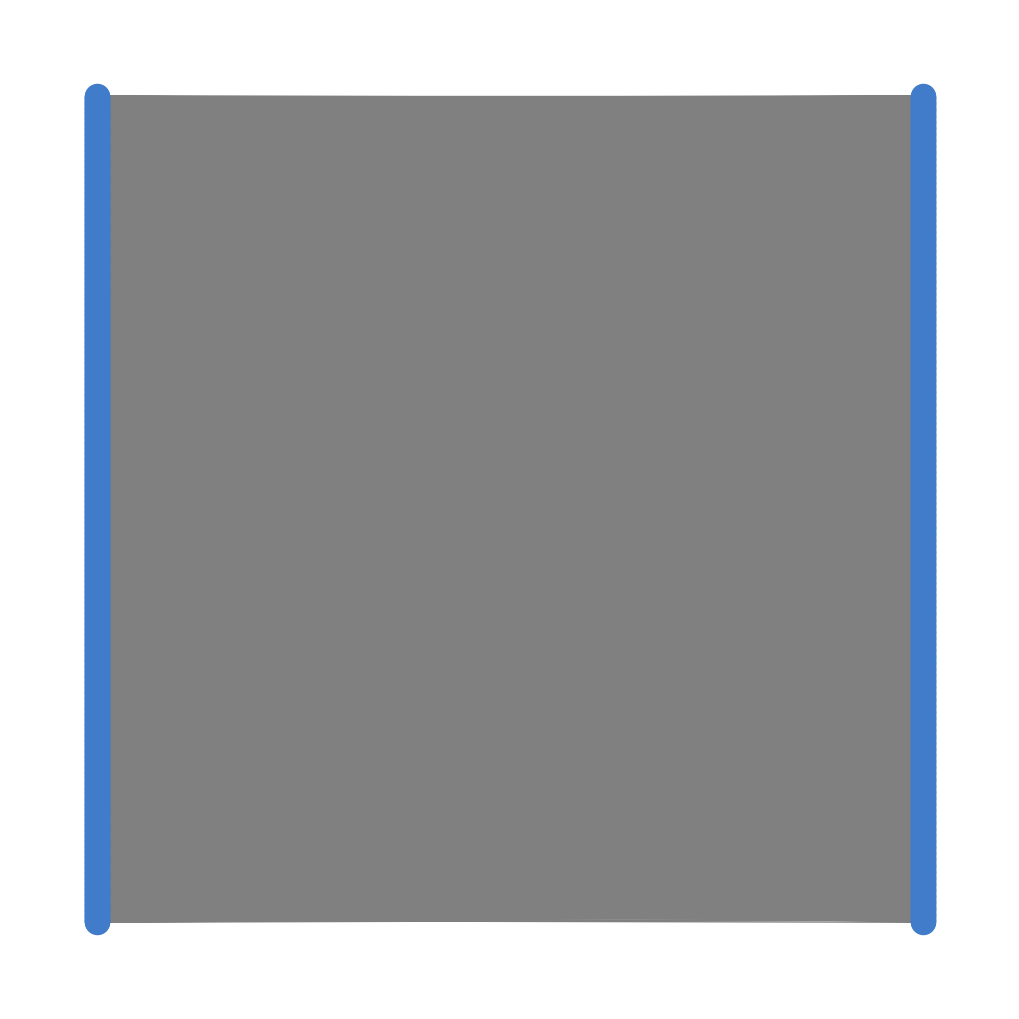

In [34]:
plt.figure(figsize=(10,10))
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw(G, pos=pos, with_labels=False, node_color=default_node_color, edge_color=default_edge_color)
plt.show()

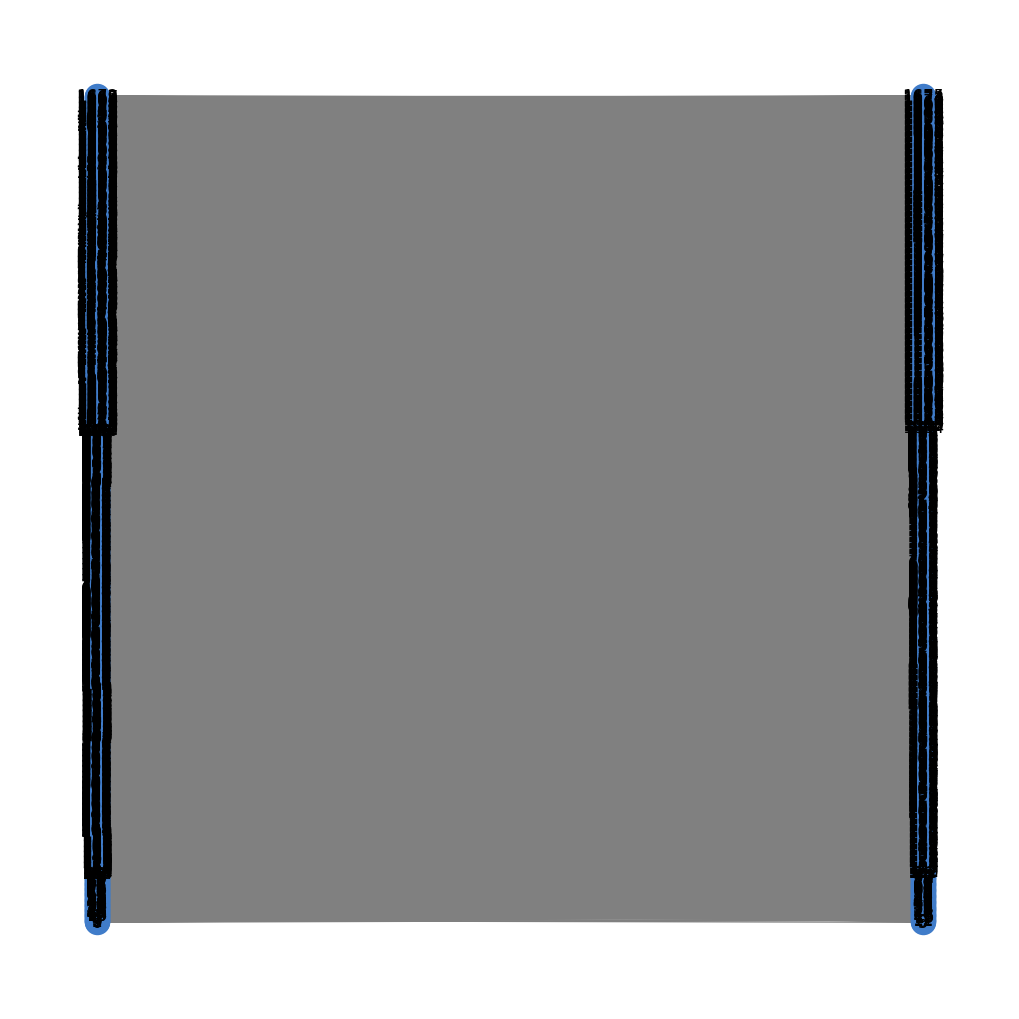

In [36]:
plt.figure(figsize=(10,10))
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw(G, pos=pos, with_labels=True, node_color=default_node_color, edge_color=default_edge_color)
plt.show()

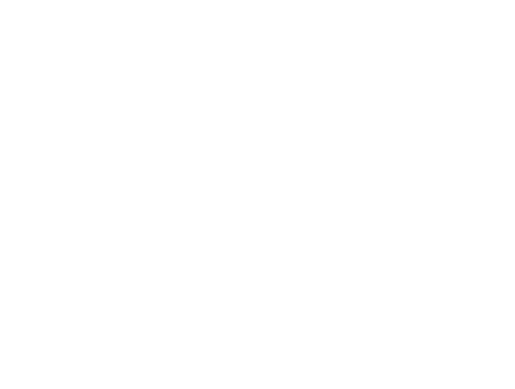

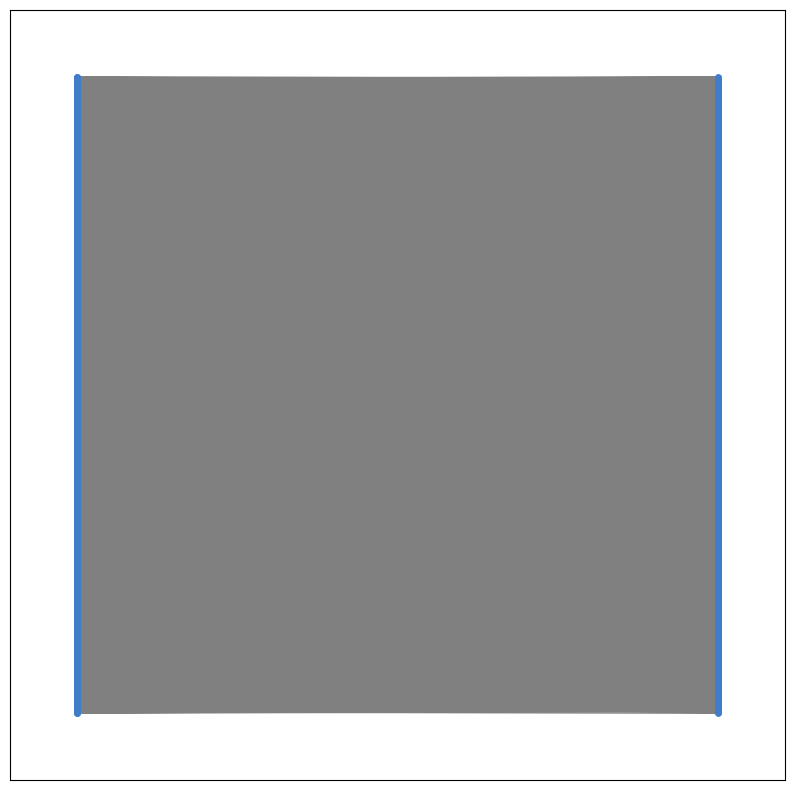

In [100]:
plt.axis("off")
plt.figure(figsize=(10,10))

# spring_pos가 선언되지 않아 에러 - 일단 pos로 바꿔줌
nx.draw_networkx(G, pos=pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=15)

## Network Analysis

In [48]:
# print(nx.info(G))  # info(): networkx 3.1에서는 사라진 메서드

# 노드와 엣지 수 출력
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

# 그래프의 노드 및 엣지 정보 확인
# print(f"Nodes: {G.nodes}")
# print(f"Edges: {G.edges}")

Number of nodes: 1676
Number of edges: 201725


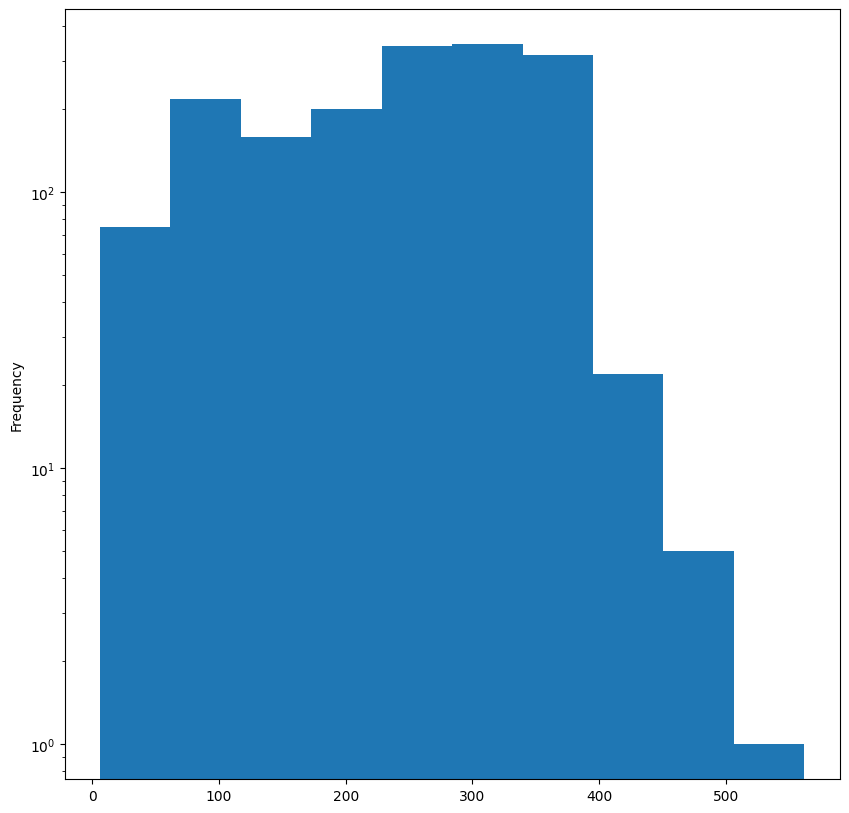

In [50]:
plt.figure(figsize=(10,10))
degrees = pd.Series({k: v for k, v in nx.degree(G)})
degrees.plot.hist()
plt.yscale("log")

In [52]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0])

array([5.030000e+00, 5.825000e+01, 9.844000e+01, 2.156560e+02,
       1.530595e+04])

In [54]:
quant_dist = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9])
quant_dist

array([  5.03 ,  58.25 ,  98.44 , 215.656])

In [56]:
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                     if d[2]["weight"] < quant_dist[-1]})

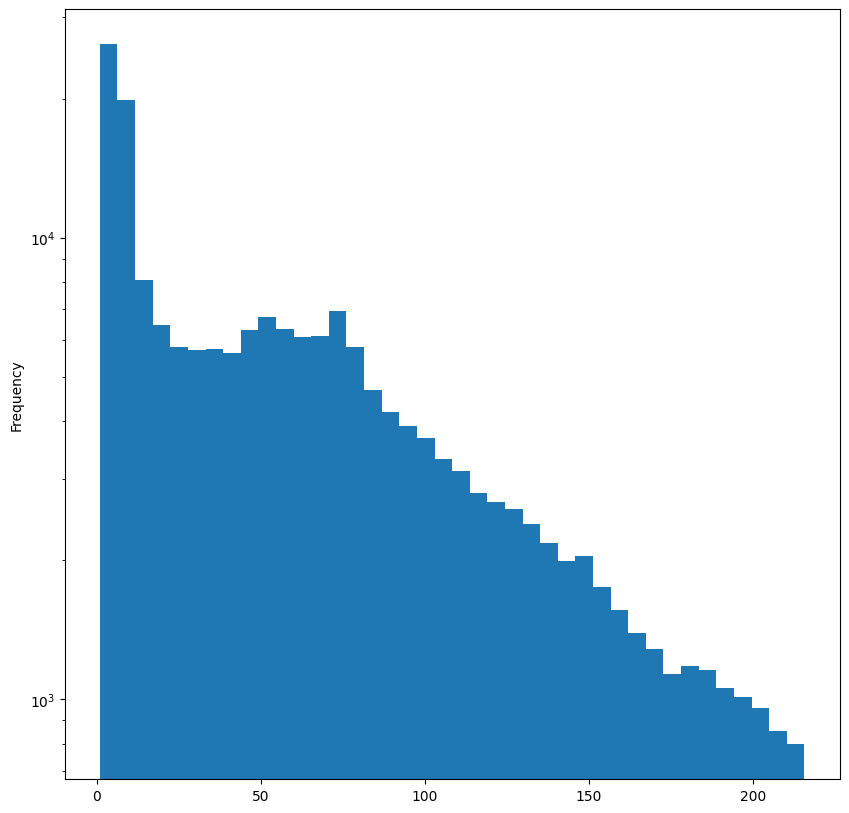

In [58]:
plt.figure(figsize=(10,10))
allEdgesWeightsFiltered.plot.hist(bins=40)
plt.yscale("log")

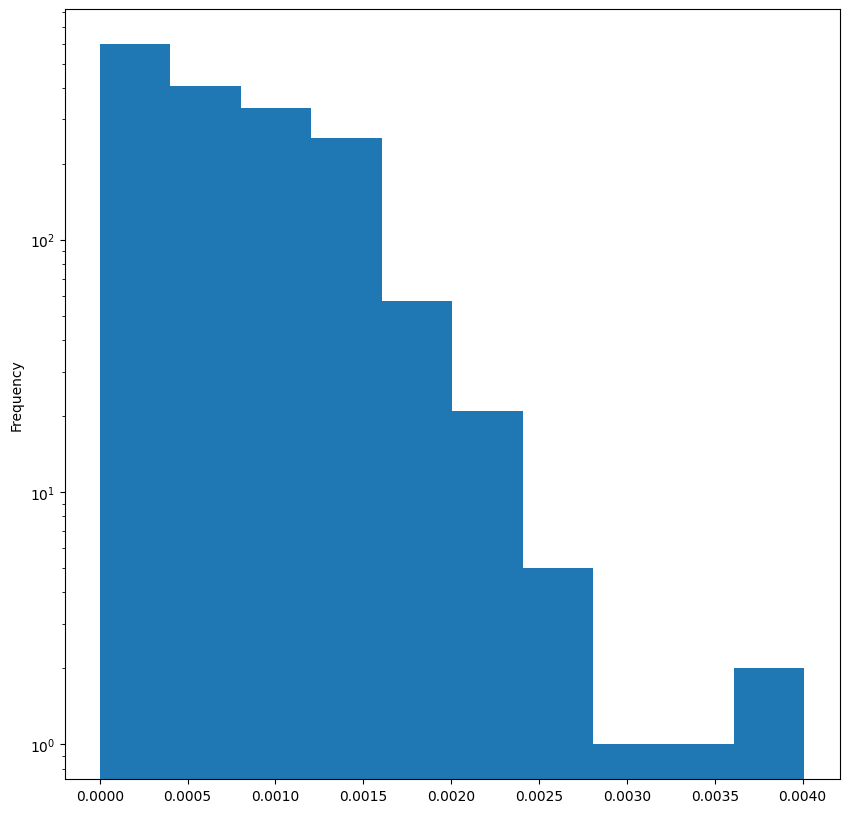

In [60]:
plt.figure(figsize=(10,10))
bC = nx.betweenness_centrality(G)
bc_distr = pd.Series(bC)
bc_distr.plot.hist()
plt.yscale("log")

In [64]:
np.mean(list(bC.values()))

0.000720547185799644

<Axes: ylabel='Frequency'>

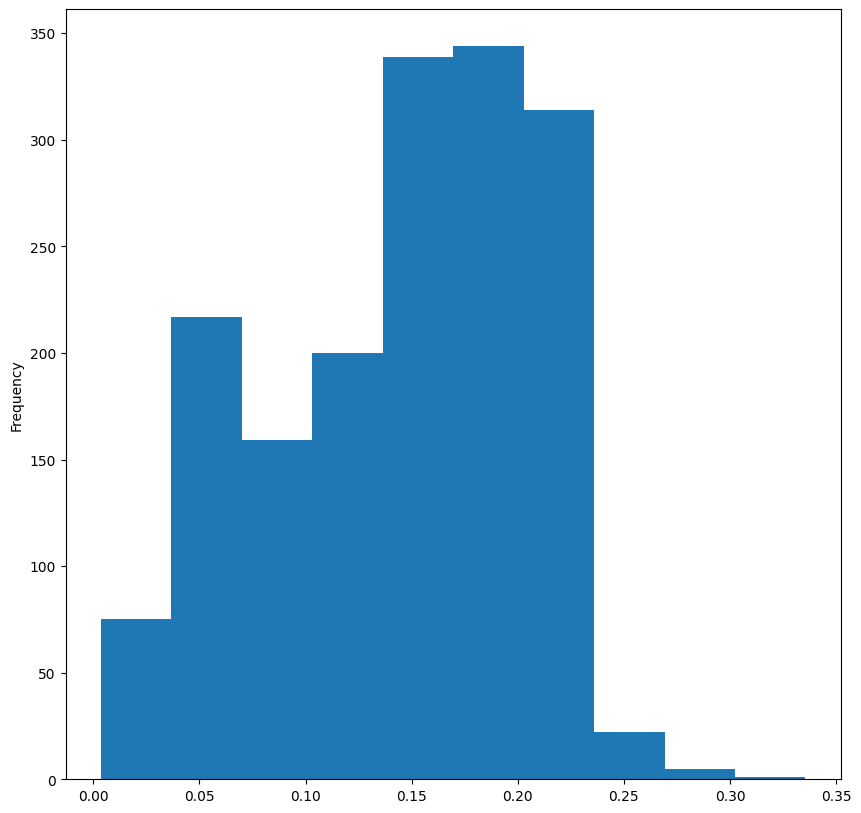

In [66]:
# degree centrality
plt.figure(figsize=(10,10))
deg_C = nx.degree_centrality(G)
degc_distr = pd.Series(deg_C)
degc_distr.plot.hist()

<Axes: ylabel='Frequency'>

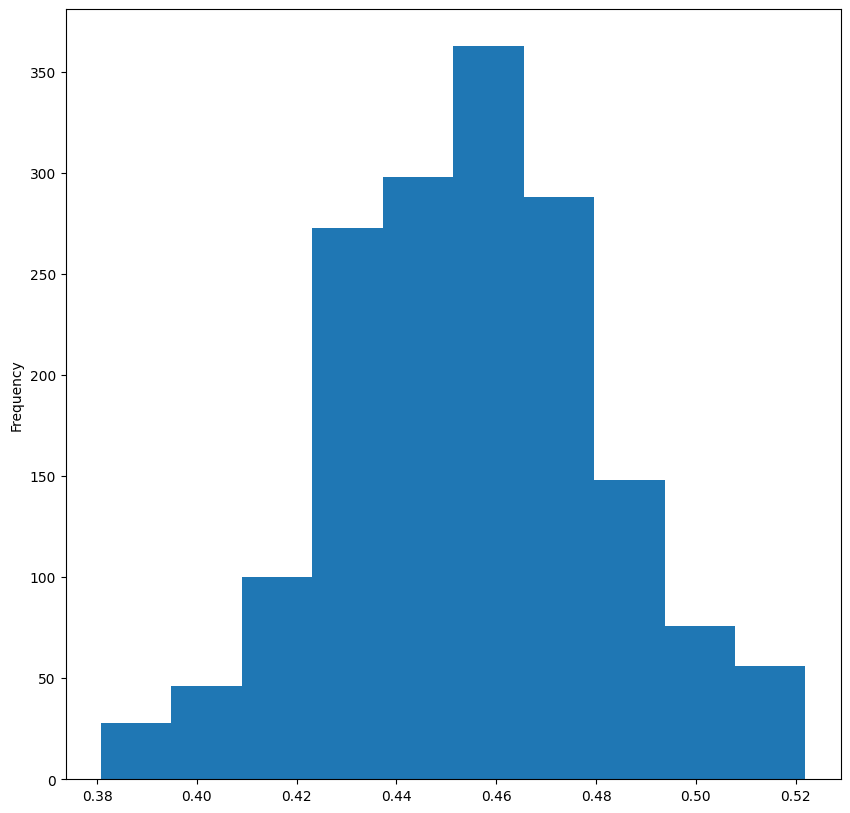

In [68]:
# closeness centrality
plt.figure(figsize=(10,10))
clos_C = nx.closeness_centrality(G)
closc_distr = pd.Series(clos_C)
closc_distr.plot.hist()

In [70]:
np.mean(list(clos_C.values()))

0.45484068767616925

In [72]:
# assortativity
nx.degree_pearson_correlation_coefficient(G)

-0.13774320410492502

### Community Detection

In [75]:
import community.community_louvain as community

parts = community.best_partition(G, random_state=42, weight='weight')
# best_partition이 없다고 하면 python-louvain을 설치해야 함

In [77]:
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

0     195
10    149
12    130
11    123
3     122
6     118
2     104
1      97
13     89
7      88
5      73
8      64
16     56
19     56
15     50
4      49
17     48
14     32
9      20
18     13
Name: count, dtype: int64

In [79]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

16    14.429530
3     13.872255
19    13.758389
1     13.237064
13    11.982249
5     11.464968
7     11.093502
9     10.000000
12     9.679618
17     9.523810
2      9.401709
15     9.205021
11     8.778626
8      7.466063
0      6.611570
4      6.147541
6      5.922551
10     4.175476
14     0.909091
18     0.000000
dtype: float64

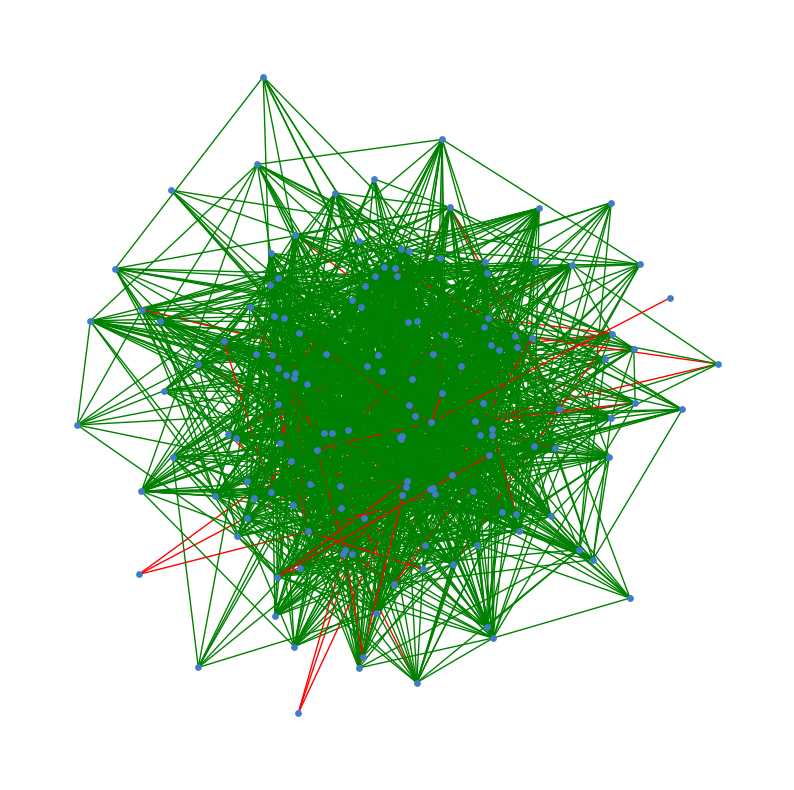

In [81]:
gId = 10
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

## Supervised Learning

In [84]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

is_fraud
1    7506
0    7506
Name: count, dtype: int64


In [86]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [88]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [90]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)
# size가 없다고 에러 -> gensim을 3.8.3버전으로 다운그레이드 해서 해결(이 경우 런타임 끊고 다시 시작해야함)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.14s/it]


In [92]:
# 로컬에서 10분 정도 걸림
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.7526570048309179
Recall: 0.528135593220339
F1-Score: 0.6207171314741036
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7191335740072202
Recall: 0.6752542372881356
F1-Score: 0.6965034965034965
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.6078998073217726
Recall: 0.855593220338983
F1-Score: 0.7107856941706561
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.6087584215591916
Recall: 0.8576271186440678
F1-Score: 0.7120743034055729


## Unupervised Learning

In [94]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.33s/it]


In [96]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.3403534228081789
Homogeneity: 0.32908341454535783
Completeness: 0.3524949463516239
V-Measure: 0.34038709915236925
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.06782957604208426
Homogeneity: 0.0667554763865439
Completeness: 0.0690355217715583
V-Measure: 0.06787635713655035
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.06406882112433536
Homogeneity: 0.06411716075608395
Completeness: 0.0641128663172198
V-Measure: 0.06411501346474124
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.04994080431921152
Homogeneity: 0.04938560155374473
Completeness: 0.050605825098924716
V-Measure: 0.0499882679605166
